In [2]:
%matplotlib inline

import os
import warnings
import collections
from datetime import timedelta

import matplotlib as mpl
from matplotlib import pylab as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np

warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
import timeit

import plot_functions as pfn
import pandas as pd

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

sns.set_context("notebook", font_scale=1.)
sns.set_style("whitegrid")
%config InlineBackend.figure_format = 'retina'

print( 'tf version', tf.__version__ )

tf version 2.0.0


In [3]:
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
from tensorflow_probability import sts
print( 'tfp version,', tfp.__version__ )

tfp version, 0.8.0


In [4]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  device_name = '/device:CPU:0'

print( device_name )
    



This error most likely means that this notebook is not configured to use a GPU.  Change this in Notebook Settings via the command palette (cmd/ctrl-shift-P) or the Edit menu.


/device:CPU:0


In [5]:
dataset_headers = ['date-time','O','H','L','C']
dataset_dtype = 'float64'
dataset_dtypes = {'O':dataset_dtype,'H':dataset_dtype,'L':dataset_dtype,'C':dataset_dtype}
dataset_file = 'xauusd_d.csv'
dataset_sep = ','

dataset = pd.read_csv( dataset_file, sep=dataset_sep, names=dataset_headers, dtype=dataset_dtypes )
dataset['date-time'] =  pd.to_datetime( dataset['date-time'], format='%Y-%m-%d')

dataset = dataset.set_index( ['date-time'] )

dataset = dataset.resample('D').pad()
dataset.tail(10)

,O,H,L,C
date-time,,,,
2020-01-22,1558.63,1559.29,1550.27,1558.90
2020-01-23,1559.00,1567.99,1552.07,1562.91
2020-01-24,1562.82,1575.86,1556.68,1571.66
2020-01-25,1562.82,1575.86,1556.68,1571.66
2020-01-26,1562.82,1575.86,1556.68,1571.66
2020-01-27,1581.29,1588.41,1576.00,1582.04
2020-01-28,1581.79,1583.07,1565.65,1567.29
2020-01-29,1567.04,1578.02,1563.47,1576.82
2020-01-30,1577.16,1586.18,1572.40,1574.47


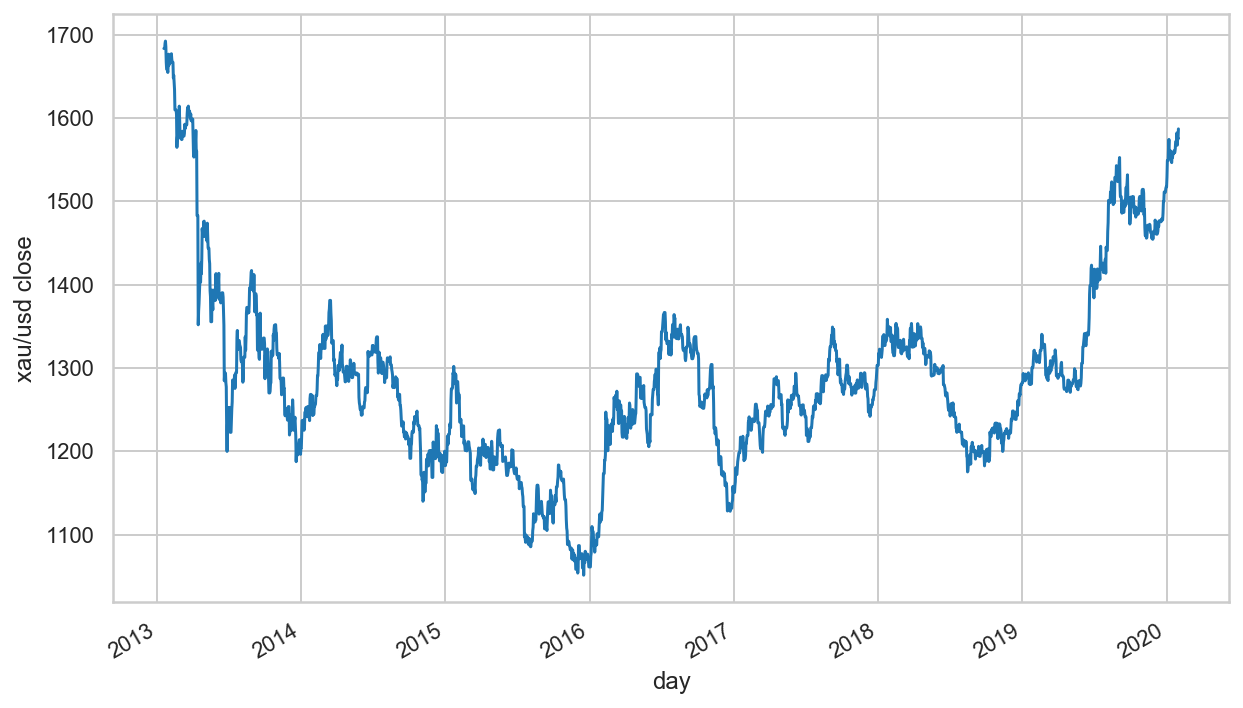

In [6]:
divisible_by_hour=0
num_forecast_steps=30
window=2600+(divisible_by_hour-num_forecast_steps)
#window=16000+(divisible_by_hour-num_forecast_steps)

close_by_minute=dataset['C'][-window:]
close_minutes=np.arange(start=0,stop=window)
close_dates=dataset.index[-window:]

fig = plt.figure( figsize=(10,6) )
ax = fig.add_subplot( 1, 1, 1 )
ax.plot( close_by_minute, label="training data" )
ax.set_ylabel("xau/usd close")
ax.set_xlabel("day")
fig.autofmt_xdate()

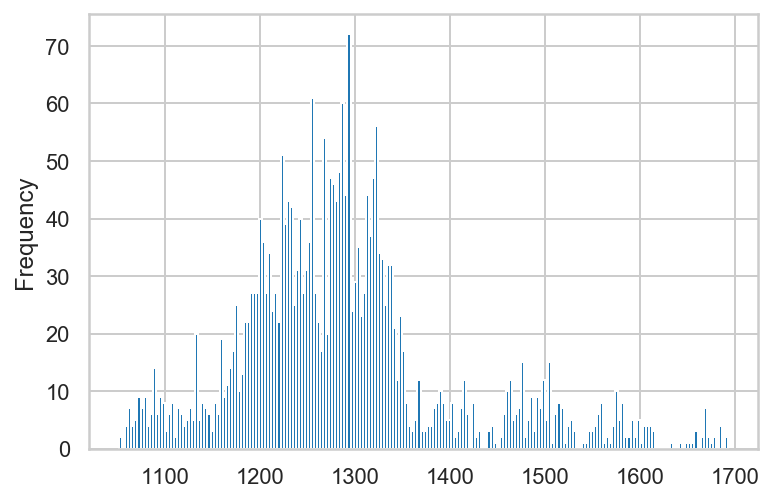

In [7]:
close_by_minute.plot.hist(bins=200)

In [8]:
def build_model( observed_time_series ):
  
  baseline = sts.SemiLocalLinearTrend( 
      observed_time_series=observed_time_series, 
      name='baseline' 
  )
  weekly = sts.Seasonal( 
      num_seasons=52,
      num_steps_per_season=7, 
      observed_time_series=observed_time_series,
      name='weekly'
  )
  monthly = sts.Seasonal( 
      num_seasons=12,
      num_steps_per_season=30, 
      observed_time_series=observed_time_series,
      name='monthly'
  )
  quarterly = sts.Seasonal( 
      num_seasons=4,
      num_steps_per_season=90, 
      observed_time_series=observed_time_series,
      name='quarterly'
  )
  residual = sts.Autoregressive(
      order=2,
      observed_time_series=observed_time_series, 
      name='residual'
  )
    
  model = sts.Sum( [ baseline, weekly, monthly, quarterly, residual ], observed_time_series=observed_time_series )
  return model

In [9]:
close_model = build_model( close_by_minute )
variational_posteriors = sts.build_factored_surrogate_posterior( model=close_model )


Instructions for updating:
SeedStream has moved to `tfp.util.SeedStream`.


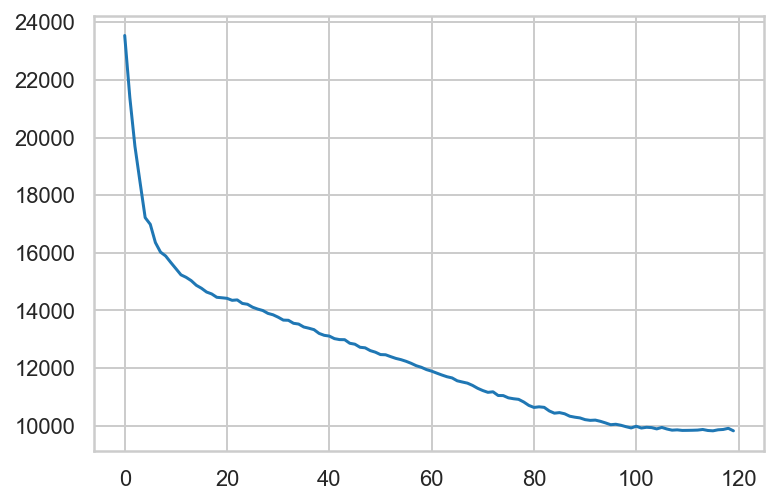

In [10]:
num_variational_steps=int(120)
optimizer = tf.optimizers.Adam( learning_rate=0.05 )

def train():
    elbo_loss_curve = tfp.vi.fit_surrogate_posterior( 
        target_log_prob_fn = close_model.joint_log_prob( observed_time_series = close_by_minute ),
        surrogate_posterior = variational_posteriors,
        optimizer = optimizer,
        num_steps = num_variational_steps )
    return elbo_loss_curve

def train_with_hmc():
    q_samples,kernel_results = tfp.sts.fit_with_hmc(
        model=close_model,
        observed_time_series=close_by_minute,
        num_variational_steps=num_variational_steps,
        variational_optimizer=optimizer,
        variational_sample_size=1
    )
    print("acceptance rate: {}".format(np.mean(kernel_results.inner_results.inner_results.is_accepted, axis=0)))
    return q_samples

is_train_with_vi=True
if is_train_with_vi:
    
    with tf.device( device_name ):
        elbo_loss_curve = train()
        q_samples = variational_posteriors.sample( 30 )

    plt.plot( elbo_loss_curve )

else:
    
    with tf.device( device_name ):
        q_samples = train_with_hmc()
        

In [11]:
print( 'Inferred parameters')
if is_train_with_vi:
    for param in close_model.parameters:
        print( "{}: {} +- {}".format( param.name, np.mean(q_samples[param.name], axis=0), np.std(q_samples[param.name], axis=0)))
else:
    for index,param in enumerate(close_model.parameters):
        print( "{}: {} +- {}".format( param.name, np.mean(q_samples[index], axis=0), np.std(q_samples[index], axis=0)))
    

Inferred parameters
observation_noise_scale: 0.9063983370161323 +- 0.15674858106606798
baseline/_level_scale: 4.040151355843899 +- 0.08432552808923861
baseline/_slope_mean: 3.5898507510604123 +- 0.6734741560576523
baseline/_slope_scale: 6.748372313720037 +- 0.16285137116753534
baseline/_autoregressive_coef: 0.20197481267735773 +- 0.022815114454159437
weekly/_drift_scale: 1.5042899834339656 +- 0.7266392894953382
monthly/_drift_scale: 2.2445112607630575 +- 0.4311079285926643
quarterly/_drift_scale: 5.058666307946203 +- 2.3184900876585397
residual/_coefficients: [0.8907058  0.01082231] +- [0.00591184 0.01038556]
residual/_level_scale: 4.719283076587204 +- 0.05733534803978672


In [12]:
with tf.device( device_name ):
    close_forecast_dist = sts.forecast( 
        close_model, 
        observed_time_series=close_by_minute,
        parameter_samples=q_samples, 
        num_steps_forecast=num_forecast_steps 
    )


In [13]:
num_samples = 60
close_forecast_mean, close_forecast_scale, close_forecast_samples = (
    close_forecast_dist.mean().numpy()[...,0],
    close_forecast_dist.stddev().numpy()[...,0],
    close_forecast_dist.sample(num_samples).numpy()[...,0]
)


In [14]:
def plot_future_forecast( x, y,
                  forecast_mean, forecast_scale, forecast_samples,
                  title, x_locator=None, x_formatter=None, add_forecast_steps=30):

  colors = sns.color_palette()
  c1, c2 = colors[0], colors[1]
  fig = plt.figure(figsize=(10, 6))
  ax = fig.add_subplot(1, 1, 1)
    
  num_steps = len(y)
  num_steps_forecast = forecast_mean.shape[-1]
  num_steps_train = num_steps - num_steps_forecast
  #forecast_steps = np.arange(
  #    x[num_steps_train],
  #    x[num_steps_train]+timedelta(days=add_forecast_steps)).astype(datetime)
  forecast_steps = np.arange(
      x[num_steps_train]+num_steps_forecast-1,
      x[num_steps_train]+num_steps_forecast*2-1,
      dtype=x.dtype)

  ax.plot( x, y, lw=2, color=c1, label='ground truth')

  ax.plot( forecast_steps, forecast_samples.T, lw=1, color=c2, alpha=0.1)

  ax.plot( forecast_steps, forecast_mean, lw=2, ls='--', color=c2, label='forecast')
  ax.fill_between( forecast_steps,
                   forecast_mean-2*forecast_scale,
                   forecast_mean+2*forecast_scale, color=c2, alpha=0.2 )

  ymin, ymax = min( np.min(forecast_samples), np.min(y)), max(np.max(forecast_samples), np.max(y))
  yrange = ymax-ymin
  ax.set_ylim([ymin - yrange*0.1, ymax + yrange*0.1])
  ax.set_title("{}".format(title))
  ax.legend()

  if x_locator is not None:
    ax.xaxis.set_major_locator(x_locator)
    ax.xaxis.set_major_formatter(x_formatter)
    fig.autofmt_xdate()

  return fig, ax


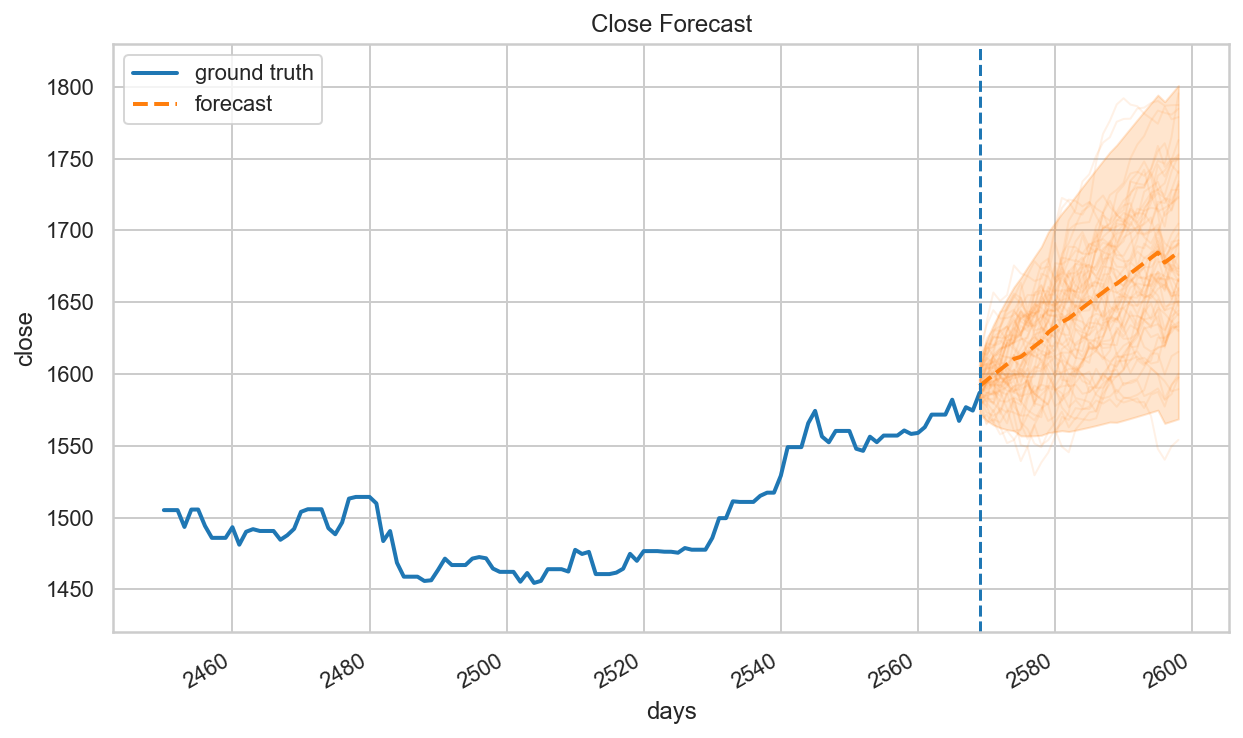

In [15]:
fig,ax=plot_future_forecast(
    close_minutes[-120:], 
    close_by_minute[-120:],
    close_forecast_mean, 
    close_forecast_scale, 
    close_forecast_samples,
    title='Close Forecast',
    add_forecast_steps=num_forecast_steps
)
ax.axvline( close_minutes[-1], linestyle="--" )
ax.legend( loc="upper left" )
ax.set_ylabel("close")
ax.set_xlabel("days")
fig.autofmt_xdate()


In [16]:
close_forecast_mean[-1]

1684.740715410401

In [17]:
with tf.device( device_name ):
    component_dists=sts.decompose_by_component( 
        close_model, 
        observed_time_series=close_by_minute, 
        parameter_samples=q_samples
    )


In [23]:
def plot_components_trim(dates,
                    component_means_dict,
                    component_stddevs_dict,
                    x_locator=None,
                    x_formatter=None, clip=50):

  colors = sns.color_palette()
  c1, c2 = colors[0], colors[1]

  axes_dict = collections.OrderedDict()
  num_components = len(component_means_dict)
  fig = plt.figure(figsize=(10, 4 * num_components))
  for i, component_name in enumerate(component_means_dict.keys()):
    component_mean = component_means_dict[component_name][clip:]
    component_stddev = component_stddevs_dict[component_name][clip:]

    ax = fig.add_subplot(num_components,1,1+i)
    ax.plot(dates[clip:], component_mean, lw=2)
    #ax.fill_between(dates[clip:],
    #                 component_mean-2*component_stddev,
    #                 component_mean+2*component_stddev,
    #                 color=c2, alpha=0.5)
    ax.set_title(component_name)
    if x_locator is not None:
      ax.xaxis.set_major_locator(x_locator)
      ax.xaxis.set_major_formatter(x_formatter)
    axes_dict[component_name] = ax
  fig.autofmt_xdate()
  fig.tight_layout()
  return fig, axes_dict


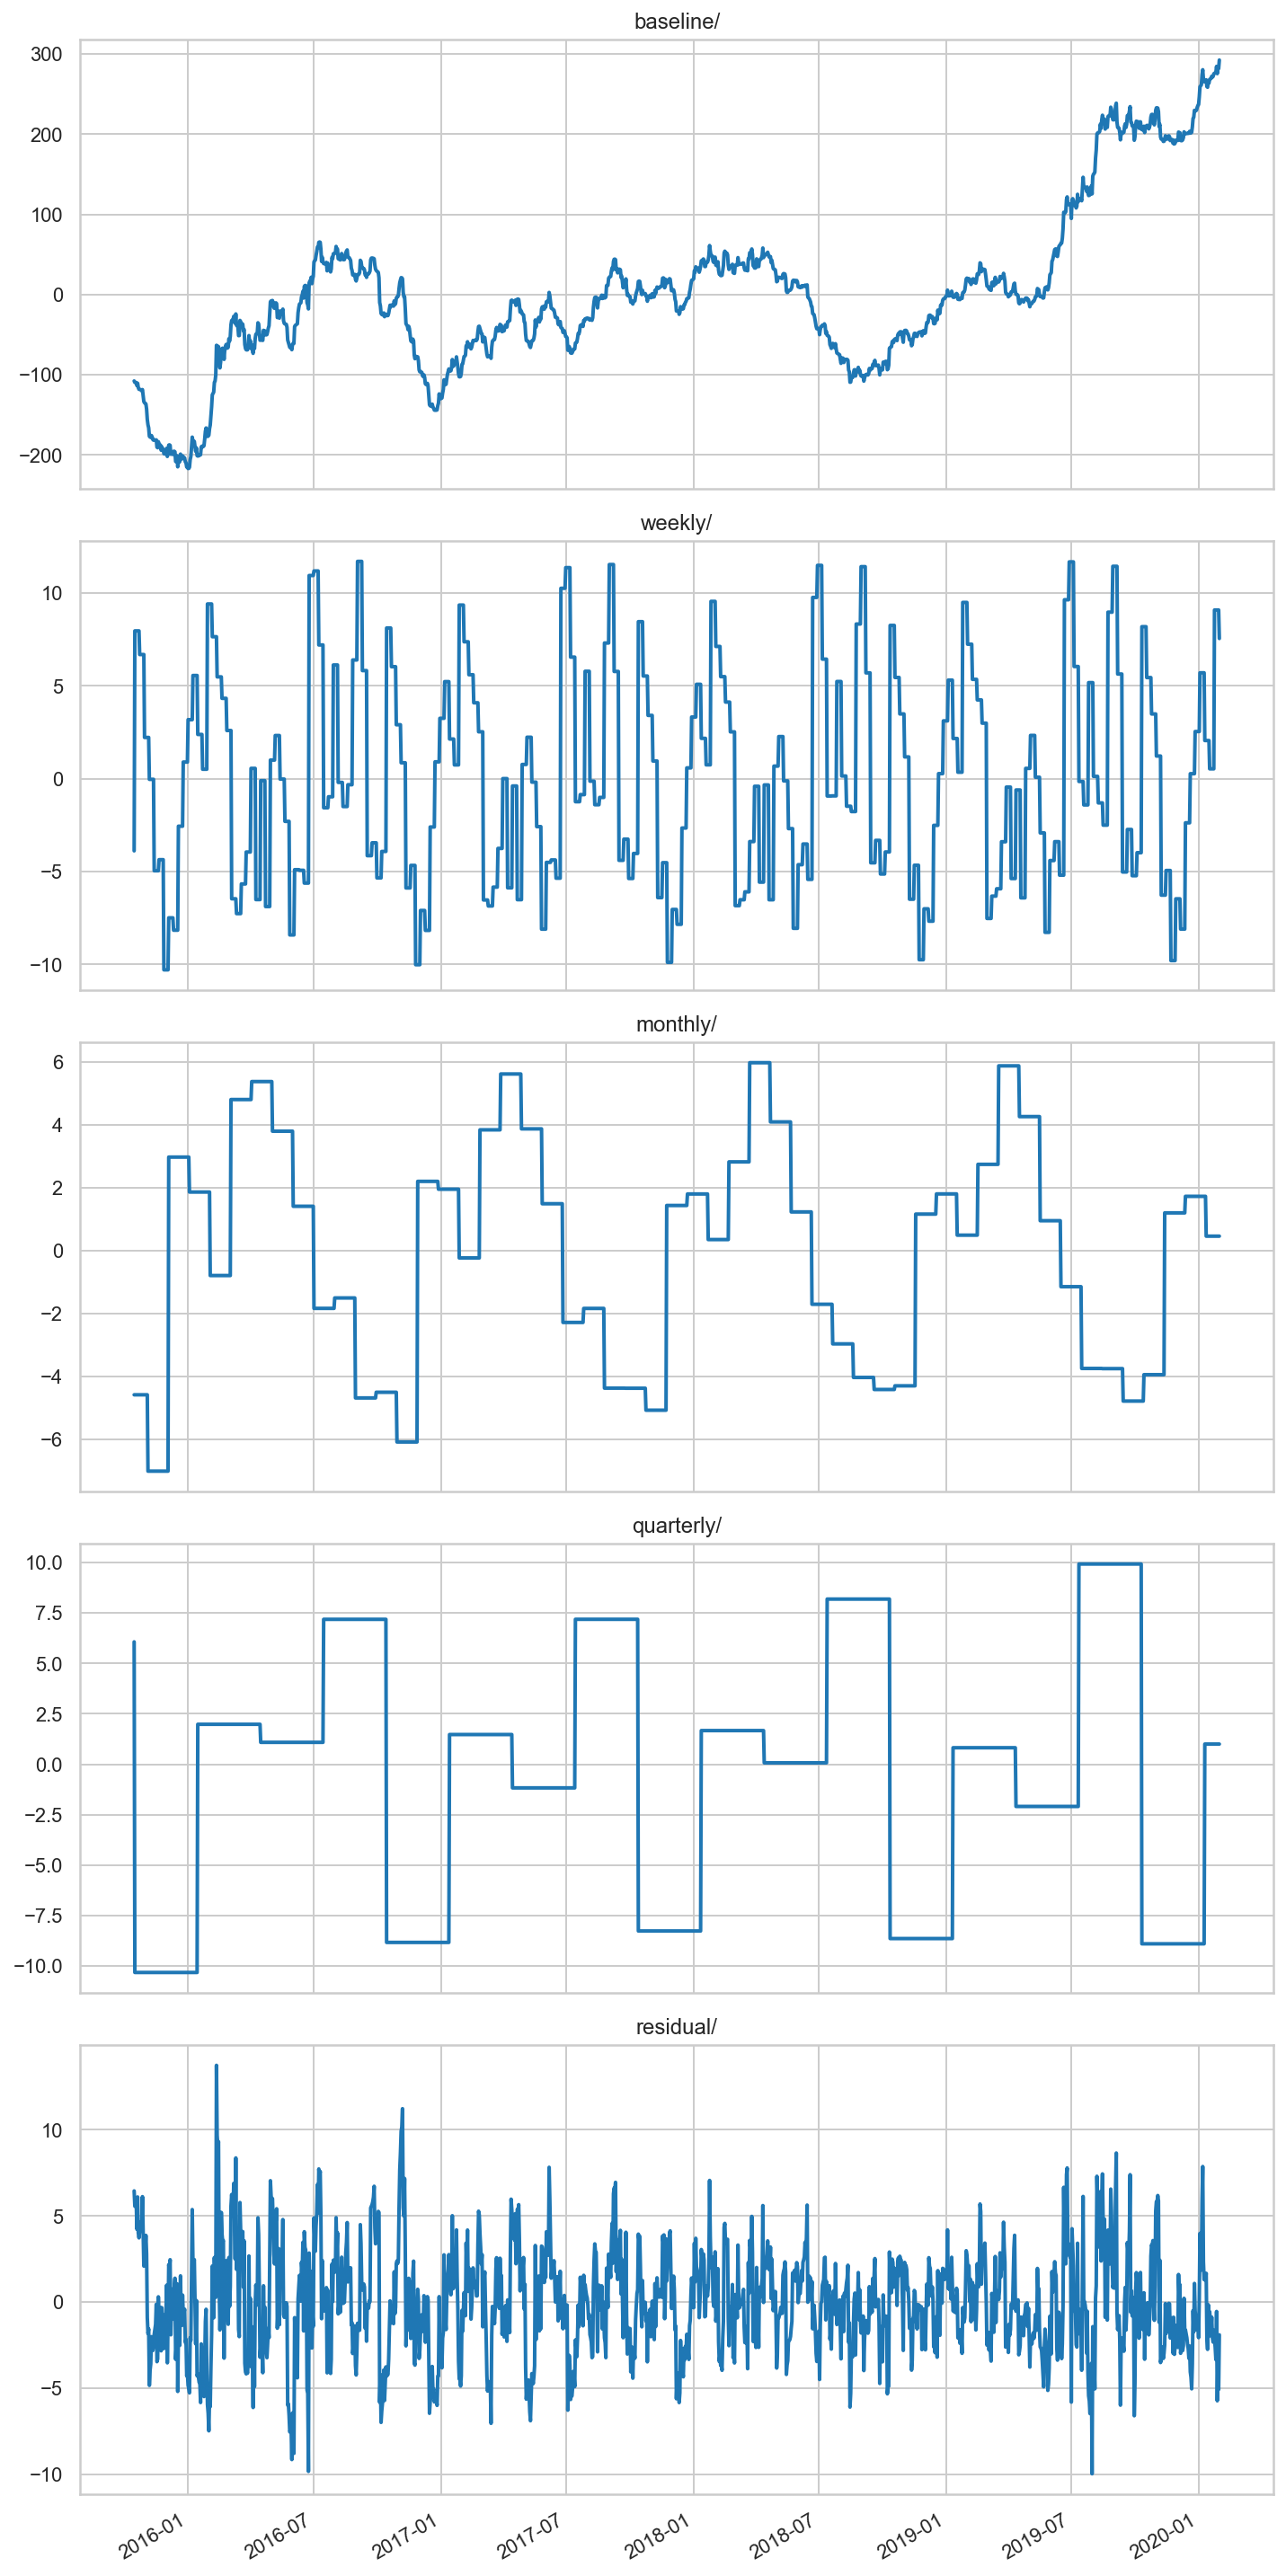

In [24]:
close_component_means, close_component_stddevs = (
    {k.name: c.mean() for k, c in component_dists.items()},
    {k.name: c.stddev() for k, c in component_dists.items()}
)

_ = plot_components_trim( close_dates, close_component_means, close_component_stddevs, clip=1000 )


In [20]:
print( close_by_minute.index[50] )
print( close_by_minute.index[-1] )

2013-03-09 00:00:00
2020-01-31 00:00:00


In [21]:
with tf.device( device_name ):

    forecast_component_dists = sts.decompose_forecast_by_component(
        close_model,
        forecast_dist=close_forecast_dist,
        parameter_samples=q_samples
    )
    forecast_component_means, forecast_component_stddevs = (
        {k.name: c.mean() for k, c in forecast_component_dists.items()},
        {k.name: c.stddev() for k, c in forecast_component_dists.items()}
    )
    

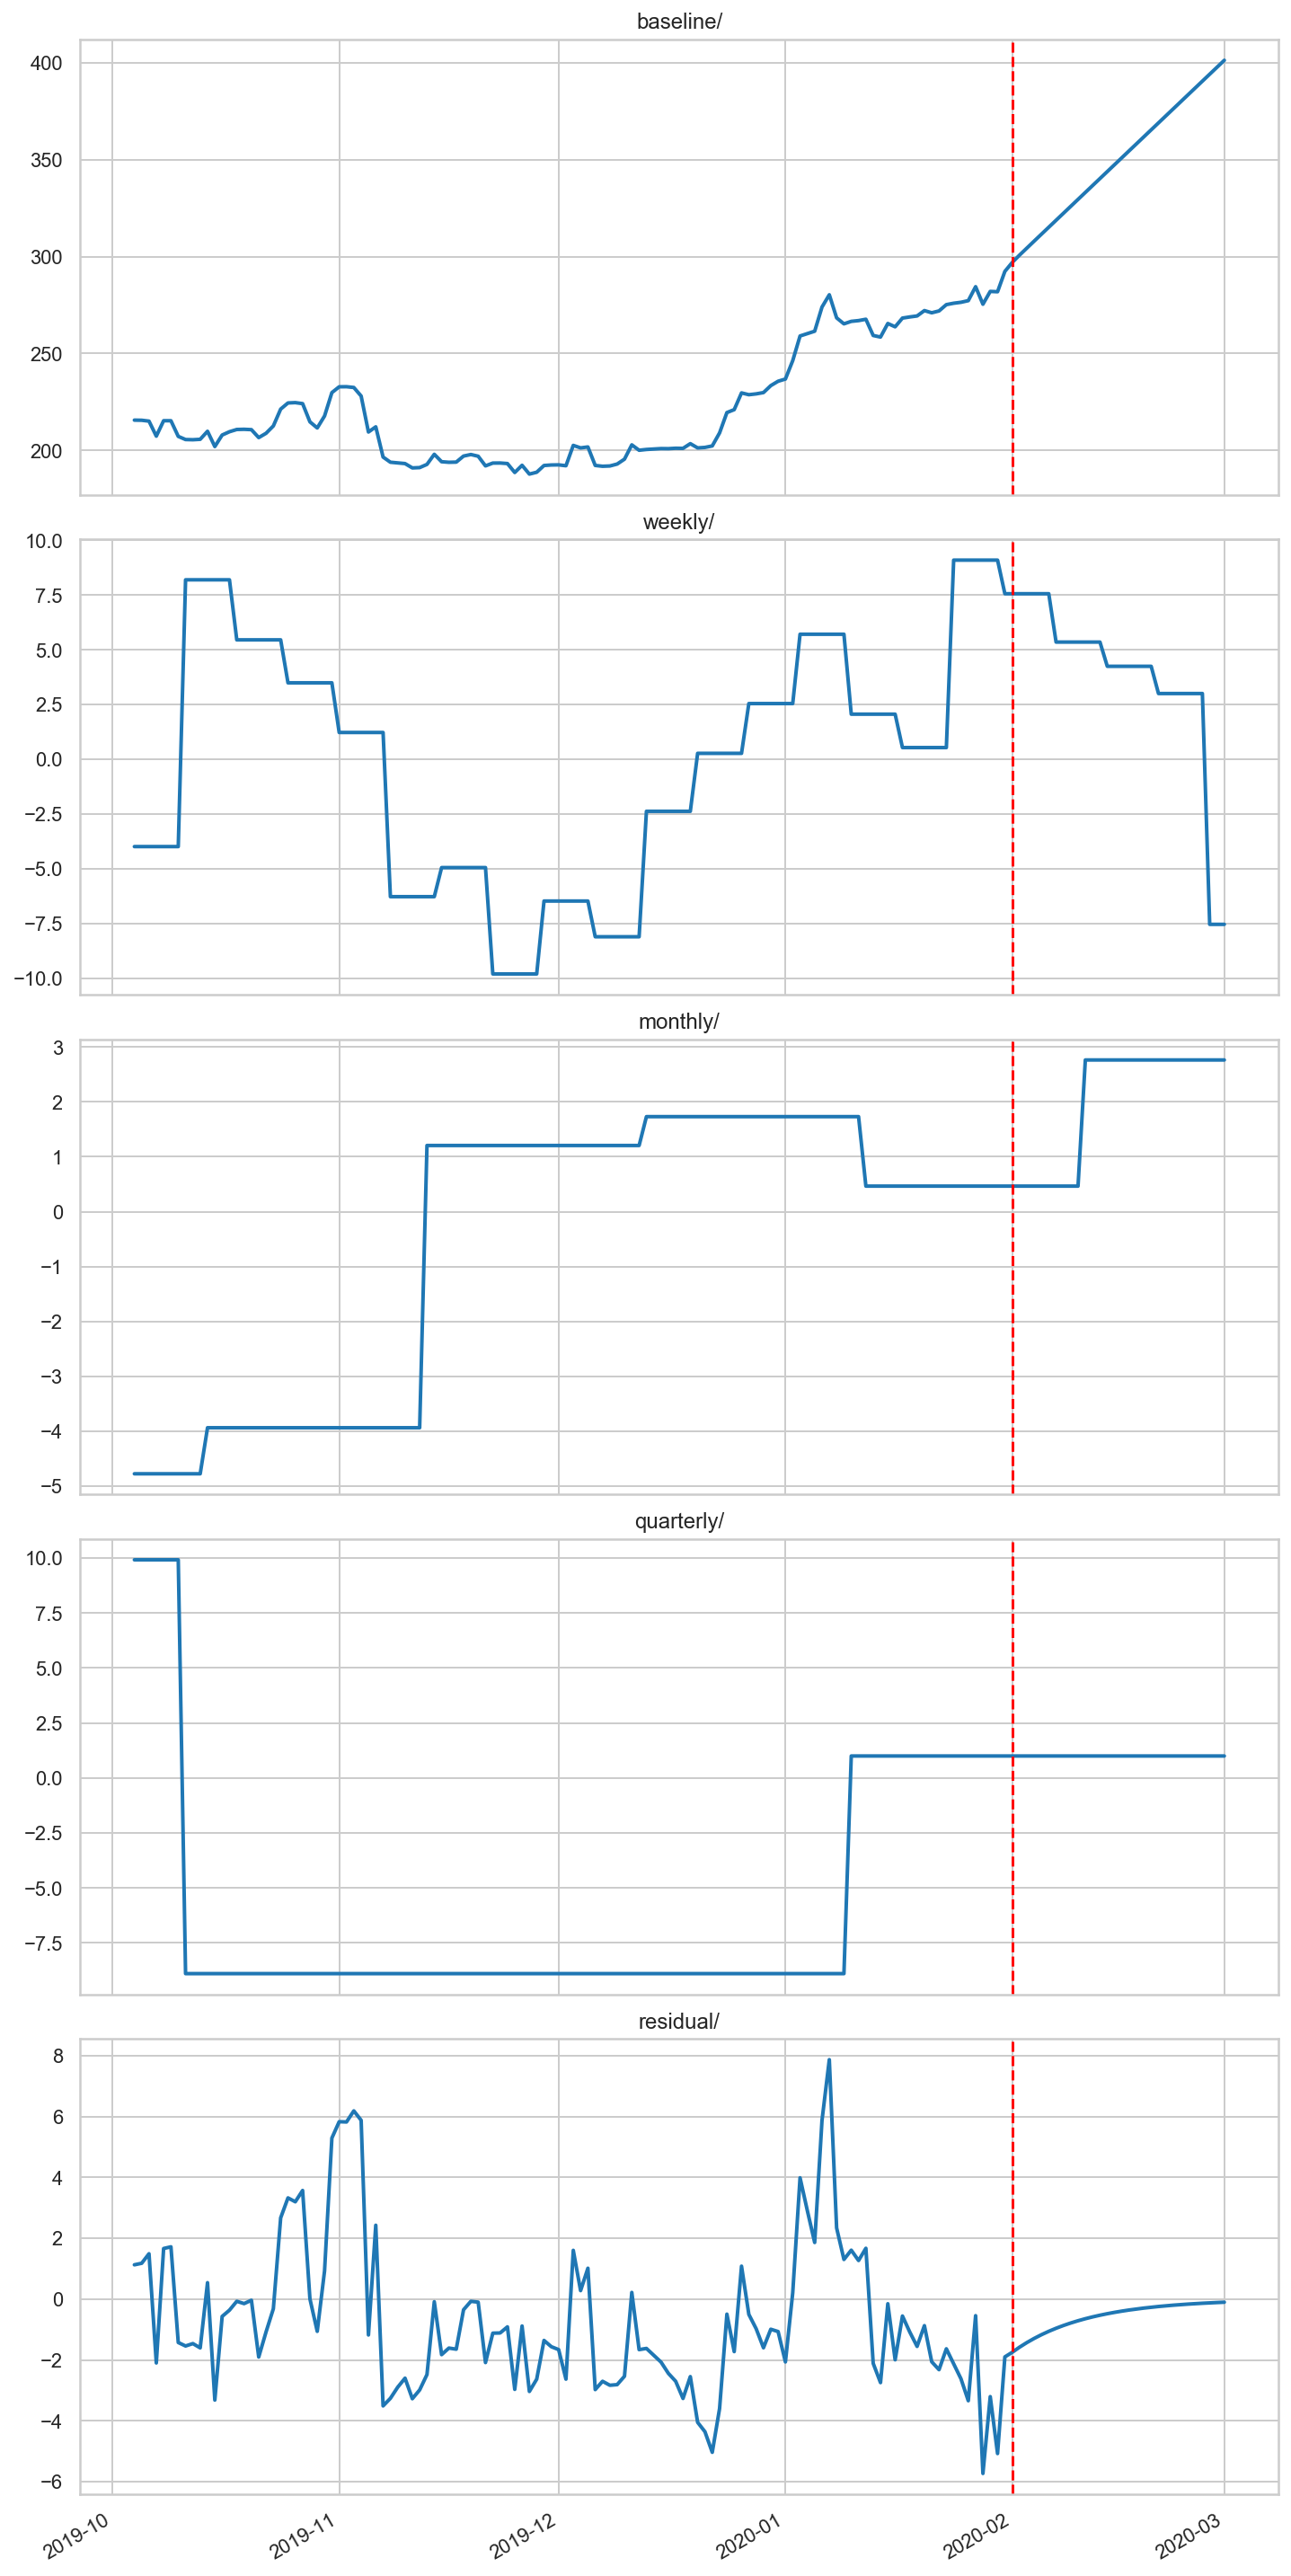

In [25]:
# Concatenate the training data with forecasts for plotting.
component_with_forecast_means = collections.OrderedDict()
component_with_forecast_stddevs = collections.OrderedDict()

for k in close_component_means.keys():
  component_with_forecast_means[k] = np.concatenate([
      close_component_means[k],
      forecast_component_means[k]], axis=-1 )
  component_with_forecast_stddevs[k] = np.concatenate([
      close_component_stddevs[k],
      forecast_component_stddevs[k]], axis=-1)

close_dates_plus = np.arange( close_dates[0], close_dates[-1] + timedelta(days=(num_forecast_steps+1)), dtype='datetime64[D]' )
fig, axes = plot_components_trim( close_dates_plus, component_with_forecast_means, component_with_forecast_stddevs, clip=window-120 )

for ax in axes.values():
  ax.axvline( close_dates_plus[-num_forecast_steps], linestyle="--", color='red')
